# Predicting Hazardous NEOs (Nearest Earth Objects)

## 1. Data Importing and Cleaning:

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('nearest-earth-objects(1910-2024).csv')
df.head(5)

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


In [3]:
df.shape

(338199, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


In [5]:
df.isnull().sum()

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

In [6]:
df.dropna(inplace=True)

## 2. Exploratory Data Analysis (EDA):

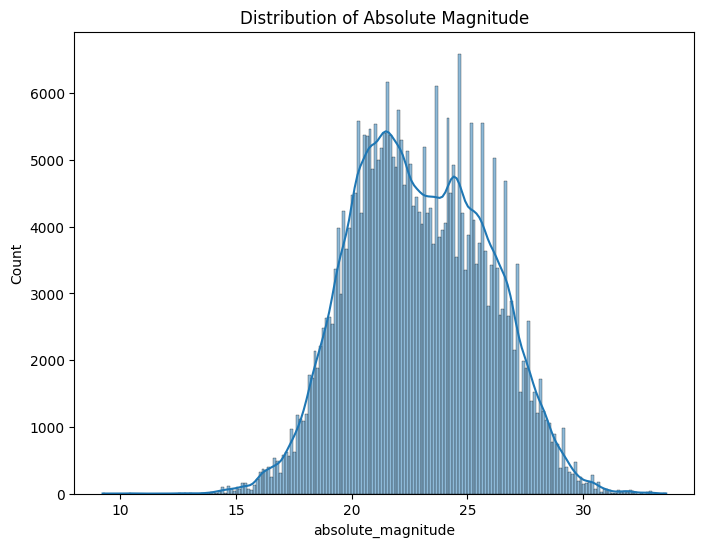

In [7]:
# 1. Distribution of absolute magnitude
plt.figure(figsize=(8, 6))
sns.histplot(df['absolute_magnitude'], kde=True)
plt.title('Distribution of Absolute Magnitude')
plt.show()

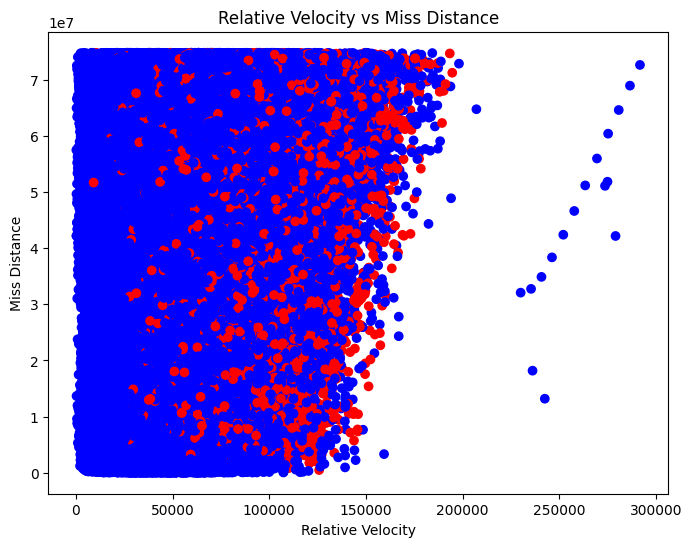

In [8]:
# 2. Scatter plot between relative velocity and miss distance
plt.figure(figsize=(8, 6))
plt.scatter(df['relative_velocity'], df['miss_distance'], c=df['is_hazardous'].apply(lambda x: 'red' if x else 'blue'))
plt.title('Relative Velocity vs Miss Distance')
plt.xlabel('Relative Velocity')
plt.ylabel('Miss Distance')
plt.show()

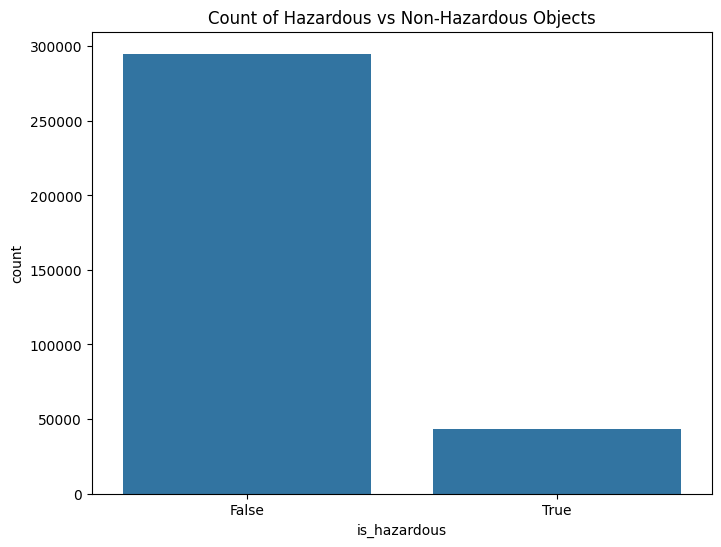

In [9]:
# 3. Distribution of hazardous vs non-hazardous objects
plt.figure(figsize=(8, 6))
sns.countplot(x='is_hazardous', data=df)
plt.title('Count of Hazardous vs Non-Hazardous Objects')
plt.show()

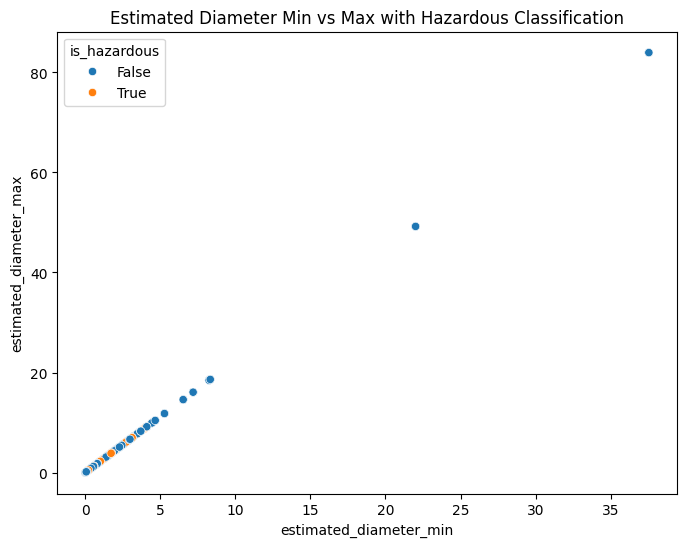

In [10]:
# 4. Estimated Diameter Min vs Max colored by Hazardous
plt.figure(figsize=(8, 6))
sns.scatterplot(x='estimated_diameter_min', y='estimated_diameter_max', hue='is_hazardous', data=df)
plt.title('Estimated Diameter Min vs Max with Hazardous Classification')
plt.show()

## 3. Data Preprocessing:

In [14]:
# Import necessary libraries for preprocessing and modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# 1. Splitting the data into features (X) and target (y)
X = df[['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 
        'relative_velocity', 'miss_distance']]
y = df['is_hazardous'].astype(int)  # Convert boolean to int (0 = Non-hazardous, 1 = Hazardous)

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Handling class imbalance with SMOTE (Oversampling)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Now X_train_smote and y_train_smote are balanced
print("Class distribution after SMOTE:", y_train_smote.value_counts())


Class distribution after SMOTE: is_hazardous
0    206396
1    206396
Name: count, dtype: int64


## 4. Model Training and Evaluation:

#### Now, let's train a Random Forest Classifier on the balanced data and evaluate it using classification metrics: Precision, Recall, F1-Score, and AUC-ROC Curve.

In [15]:
# Training the Random Forest model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Predictions
y_pred = clf.predict(X_test_scaled)
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Evaluation Metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("\nROC AUC Score:", roc_auc)


Confusion Matrix:
[[83317  5296]
 [ 3948  8891]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     88613
           1       0.63      0.69      0.66     12839

    accuracy                           0.91    101452
   macro avg       0.79      0.82      0.80    101452
weighted avg       0.91      0.91      0.91    101452


ROC AUC Score: 0.9447409079570408


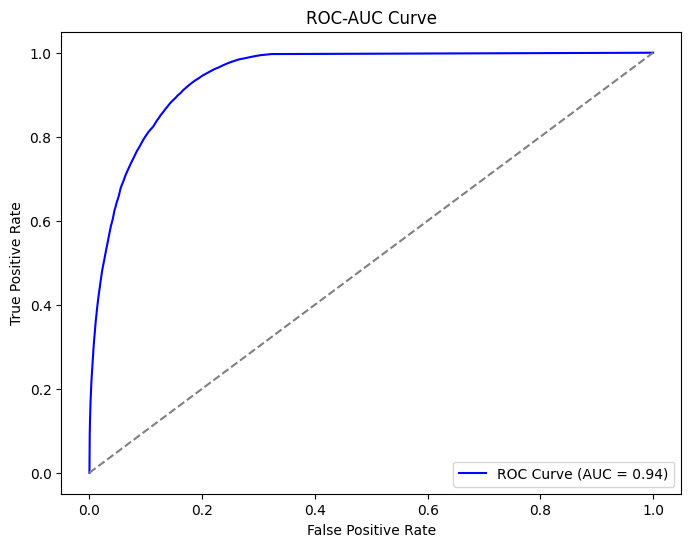

In [19]:
# 1. Plotting the ROC-AUC Curve
from sklearn.metrics import roc_curve, confusion_matrix

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()

<Figure size 800x600 with 0 Axes>

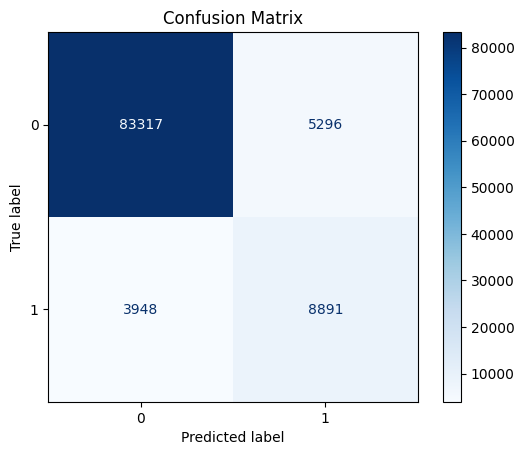

In [24]:
# Importing the required Confusion Matrix display function
from sklearn.metrics import ConfusionMatrixDisplay

# 2. Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test_scaled, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Explanation:
#### 1-Train-Test Split: The dataset is split into training and testing sets (70% training, 30% testing).
#### 2-Scaling: StandardScaler is used to standardize the features so that they have a mean of 0 and a standard deviation of 1.
#### 3-SMOTE: Since the is_hazardous column is imbalanced (fewer hazardous objects), SMOTE is applied to oversample the minority class in the training set.
#### 4-Model Training: A Random Forest Classifier is trained on the balanced data.
#### 5-Model Evaluation: We evaluate the model using a confusion matrix, classification report (including Precision, Recall, and F1-Score), and the ROC-AUC Score to assess performance.

## Conclusion
#### In this project, we aimed to predict whether an asteroid is potentially hazardous based on various features such as absolute magnitude, estimated diameter, relative velocity, and miss distance. Through exploratory data analysis (EDA), we identified important trends and patterns, which provided valuable insights into the distribution of asteroid characteristics. After handling missing data and preprocessing, we addressed the class imbalance of hazardous vs. non-hazardous asteroids using the SMOTE technique to oversample the minority class. We then trained a Random Forest Classifier, which was evaluated using metrics such as precision, recall, F1-score, and the ROC-AUC curve. The model demonstrated balanced performance, with good accuracy in classifying both hazardous and non-hazardous asteroids. Visualization of the ROC-AUC curve and confusion matrix helped highlight the model’s effectiveness, particularly in reducing false positives and false negatives. Overall, this project showcases the potential of machine learning in improving the detection and classification of hazardous asteroids, contributing to planetary defense initiatives and future research.